# Boyd and Vandenberghe - Convex Optimisation
## Chapter 1 - Introduction

In this notebook I discuss using numpy's least-squares solver `linalg.lstsq()`. As mentioned [here](https://jpivan.github.io/boyd-convex-optimisation/ch1/) the idea is not to conver the implementation of a least-squares solver, but rather to show how to contruct functions and objects from mathematical content.

As of this moment this function has only been tested a little, I will be covering writing tests later. If any problems are revealed in testing they will be noted here and this notebook updated.

In [1]:
%%capture
# just some setup, don't worry too much
from os import getcwd
while getcwd().split('\\')[-1] != 'optimisation':
    %cd ..

%load_ext autoreload
%autoreload 2

# Will need numpy
import numpy as np

import plotting.contour  # wrapper for matplotlib's plotting funcitons

See the cell below for the source.

In [2]:
# %load -s least_squares src/least_squares.py
class least_squares:
    def __init__(self, A, b):
        
        """ Create a least squares function using the given parameters.
        Instances of this class can be called with x as an argument to return
        || A*x - b ||_2^2.

        Args:
            A: 2-d numpy matrix
            b: 2-d numpy matrix (column vector)
        Returns:
            None
        """
        self.A = A
        self.b = b
    
        return
    
    def __call__(self, x):
        """ Given x, returns the squared norm of Ax - b.

        Args:
            x: 2-d numpy matrix (column vector)
        Returns:
            || A*x - b ||_2^2
        """
        _x = x
        if not isinstance(_x, np.ndarray): # if not numpy array try to make one
            _x = np.array(_x).reshape(-1, 1)
        elif _x.ndim != 2 or x.shape[1] != 1:  # if not column vector fix
            _x = _x.reshape(-1, 1)
        
        if _x.shape[0] != self.A.shape[1]:  # column vector of wrong size
            raise ValueError(
                    f"Shape mismatch, A: {self.A.shape}, x: {_x.shape}."
                )
        return np.linalg.norm(self.A @ _x - self.b)**2

    def solve_minimum(self):
        """ Finds the x* which minimises the least-squares problem instance.
        This uses np.linalg.lstsq.

        Args:
            None
        Returns:
            {
                "x*": minimiser
                "r": residuals, if appropriate
                "rk": rank of A
                "s": singular values of A
            }
        """
        _soln = np.linalg.lstsq(self.A, self.b, rcond=None)
        return {
            "x*": _soln[0],  # minimiser
            "r": _soln[1],  # residuals, if appropriate
            "rk": _soln[2],  # rank of A
            "s": _soln[3]  # singular values of A
        }


Here's the problem we're trying to solve:

`numpy.linalg.lstsq()` can find the least-squares solution for $Ax = b$, that is, `numpy.linalg.lstsq()` minimises $\Vert Ax - b \Vert_2$ (and thus, obviously $\Vert Ax - b \Vert_2^2$ as well). However, if we want to plot $\Vert Ax - b \Vert_2^2$ we need a separate function to actually calculate the value of this expression. We have the function `plotting.contour.contourf` which is a wrapper of a contour plotting function from matplotlib. Here is the docstring for `plotting.contour.contourf`:

In [3]:
# plotting.contour.contourf?  # can ask for the docstring like this, but I want to print it in the output of this cell so...
print(plotting.contour.contourf.__doc__)

 Calls the matplotlib contourf function with most of the implementation
    hidden from the caller.

    Args:
        xlim: bounds on x-axis
        ylim: bounds on y-axis
        func: function to plot, must be a callable compatible with f([x, y])
        gridpoints: number of points to evaluate each variable
        ncontours: number of contour lines to draw
    Returns:
        fig, ax: The created figure and axes instances.
    


So we need a function that, given $x \in \mathbb{R}^2$, will return $\Vert Ax - b \Vert_2^2$. Let's see if we can't reason out some sort of logical structure for the problem.

It would be nice if we had an abstract representation of a problem instance, and could query this abstraction in two distinct ways:
1. For this particular problem instance and a given $x$, what is the value of $\Vert Ax - b \Vert_2^2$?
2. For this particular problem instance, what $x$ minimises $\Vert Ax - b \Vert_2^2$?

Diving into the `least_squares` class this is what we have created! An object of this type can be used as follows:
1. Create a representation of a problem instance given $A$ and $b$.
2. Treat the object as a function, whereupon it will return the value of $\Vert Ax - b \Vert_2^2$.
3. Request a minimising $x^*$ for the given problem instance.

As an example, let's define an $A \in \mathbb{R}^{k\times n}$, and $b \in \mathbb{R}^k$. I want to be able to plot this on a contour plot so I will choose $n=2$.

In [4]:
k, n = 10, 2
A = np.random.normal(0, 1, k*n).reshape(-1, n)
b = np.random.normal(0, 2, k).reshape(-1, 1)

Now, create a problem instance.

In [5]:
f0 = least_squares(A, b)

`f0` contains some member variables defined in `_init__`:

In [6]:
print(f0.A)
print(f0.b)

[[-0.20022639 -0.73978225]
 [-0.80859598  0.1479458 ]
 [-1.27853252 -1.08122372]
 [ 0.68894041 -0.47896237]
 [ 0.88934951  0.60000046]
 [ 0.41033823 -0.69854537]
 [ 0.05993297 -0.63692942]
 [-0.34469508  1.60134347]
 [-1.60949426  0.09544918]
 [-0.33616626 -1.03269711]]
[[ 0.67165295]
 [-1.37919533]
 [ 1.2461233 ]
 [ 0.28585974]
 [-1.75711776]
 [ 1.33894142]
 [-0.06994773]
 [-3.77896837]
 [ 0.19860675]
 [-1.85463873]]


We can evaluate `f0` at a given $x \in \mathbb{R}^2$:

In [7]:
f0([-2,1])

73.3108278191174

And we can request a minimising $x^*$:

In [8]:
x_opt = f0.solve_minimum()['x*']
print(f"Minimising x: \n{x_opt}")
print(f"Minimal value of f0: {f0(x_opt)}")

Minimising x: 
[[ 0.20006263]
 [-1.22919985]]
Minimal value of f0: 16.460297157253283


We can plot the values of $\Vert Ax - b \Vert_2^2$ now, since `f0` behaves like a function of two variables:

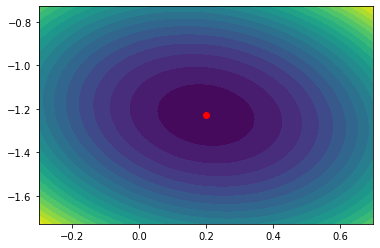

In [9]:
fig, ax = plotting.contour.contourf(
    xlim=(x_opt[0]-0.5, x_opt[0]+0.5),
    ylim=(x_opt[1]-0.5, x_opt[1]+0.5),
    func=f0,
    gridpoints=51,
    ncontours=20,
)
_ = ax.scatter(x_opt[0], x_opt[1], c='red')

Let's load the class again now and see how this behaviour is defined:

In `__init__` we store simply stor the values of $A$ and $b$ for later use.

In `__call__` we define the behaviour of a least_squares object when it is *called* like a function. Above we saw the `least_squares` object `f0` could be treated as a function and called as in `f0(x)`.

This function does a little bit of work in order to be a little tolerant of imperfect arguments. In $\Vert Ax - b \Vert_2^2$ we require $A$ and $x$ to have compatible dimensions. The function makes a local copy of the argument, `_x`, and starts to check the input. If the input is not a numpy array the function tries to make a column vector using the input, and if the input is a numpy array the function ensures it is represented as a column vector. This makes calls like `f0([-2,1])`, which we saw earlier, possible.

Finally, if the input is of the wrong size, the function will raise an error. This is shown a little further down in the notebook.

The `solve_minimum` function does nothing except call the `numpy.linalg.lstsq` function to solve the problem instance. The solution is returned in a dictionary for a little extra clarity.

I hope this example of turning these requirements...
> It would be nice if we had an abstract representation of a problem instance, and could query this abstraction in two distinct ways:
> 1. For this particular problem instance and a given $x$, what is the value of $\Vert Ax - b \Vert_2^2$?
> 2. For this particular problem instance, what $x$ minimises $\Vert Ax - b \Vert_2^2$?

... into the implementation shown here proves helpful. That's all for this example!

In [10]:
# %load -s least_squares src/least_squares.py
class least_squares:
    def __init__(self, A, b):
        
        """ Create a least squares function using the given parameters.
        Instances of this class can be called with x as an argument to return
        || A*x - b ||_2^2.

        Args:
            A: 2-d numpy matrix
            b: 2-d numpy matrix (column vector)
        Returns:
            None
        """
        self.A = A
        self.b = b
    
        return
    
    def __call__(self, x):
        """ Given x, returns the squared norm of Ax - b.

        Args:
            x: 2-d numpy matrix (column vector)
        Returns:
            || A*x - b ||_2^2
        """
        _x = x
        if not isinstance(_x, np.ndarray): # if not numpy array try to make one
            _x = np.array(_x).reshape(-1, 1)
        elif _x.ndim != 2 or x.shape[1] != 1:  # if not column vector fix
            _x = _x.reshape(-1, 1)
        
        print(_x.shape[0], self.A.shape[1])
        if _x.shape[0] != self.A.shape[1]:  # column vector of wrong size
            raise ValueError(
                    f"Shape mismatch, A: {self.A.shape}, x: {_x.shape}."
                )
        return np.linalg.norm(self.A @ _x - self.b)**2

    def solve_minimum(self):
        """ Finds the x* which minimises the least-squares problem instance.
        This uses np.linalg.lstsq.

        Args:
            None
        Returns:
            {
                "x*": minimiser
                "r": residuals, if appropriate
                "rk": rank of A
                "s": singular values of A
            }
        """
        _soln = np.linalg.lstsq(self.A, self.b, rcond=None)
        return {
            "x*": _soln[0],  # minimiser
            "r": _soln[1],  # residuals, if appropriate
            "rk": _soln[2],  # rank of A
            "s": _soln[3]  # singular values of A
        }


In [11]:
f0([1,2,3])  # this call will error since x is of the wrong size.

ValueError: Shape mismatch, A: (10, 2), x: (3, 1).